In [ ]:
!pip install -q git+https://github.com/tensorflow/docs 
import tensorflow
import pandas as pd
import time
import numpy as np

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback

import matplotlib.pyplot as plt
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Read Data

In [ ]:
df = pd.read_csv('/content/sample_data/features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [ ]:
df['label'].value_counts()

reggae       100
pop          100
jazz         100
blues        100
classical    100
country      100
disco        100
hiphop       100
rock         100
metal        100
Name: label, dtype: int64

Split and scale dataset

In [ ]:
columns_to_drop = ['label','filename', 'length']

def prepare_dataset(df, columns_to_drop, test_size, random_state):

    # Encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    # devide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # scale the training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train['label'].to_numpy()
    
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    #scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test

In [ ]:
X_train, y_train, X_test, y_test = prepare_dataset(df, columns_to_drop, test_size=0.3, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(700, 57) (700,)
(300, 57) (300,)


In [ ]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# Question 1


In [ ]:
model=Sequential([
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

In [ ]:
num_epochs=50
batch_size=1

model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=
              [#tf.keras.losses.CategoricalCrossentropy(name='ce'),
               'accuracy'])
    
history = model.fit(X_train, y_train, 
                        epochs=num_epochs, 
                        batch_size = batch_size,
                        validation_data=(X_test,y_test))


Epoch 1/50
700/700 [==============================] - 5s 3ms/step - loss: 2.2080 - accuracy: 0.2286 - val_loss: 1.7604 - val_accuracy: 0.4567
Epoch 2/50
700/700 [==============================] - 2s 3ms/step - loss: 1.6730 - accuracy: 0.4000 - val_loss: 1.5049 - val_accuracy: 0.5067
Epoch 3/50
700/700 [==============================] - 2s 3ms/step - loss: 1.4763 - accuracy: 0.4929 - val_loss: 1.3971 - val_accuracy: 0.5600
Epoch 4/50
700/700 [==============================] - 2s 3ms/step - loss: 1.3721 - accuracy: 0.5143 - val_loss: 1.2896 - val_accuracy: 0.5867
Epoch 5/50
700/700 [==============================] - 2s 3ms/step - loss: 1.2771 - accuracy: 0.5671 - val_loss: 1.2200 - val_accuracy: 0.5867
Epoch 6/50
700/700 [==============================] - 2s 3ms/step - loss: 1.1967 - accuracy: 0.5943 - val_loss: 1.1860 - val_accuracy: 0.6100
Epoch 7/50
700/700 [==============================] - 2s 3ms/step - loss: 1.1493 - accuracy: 0.6057 - val_loss: 1.1443 - val_accuracy: 0.6200
Epoch 

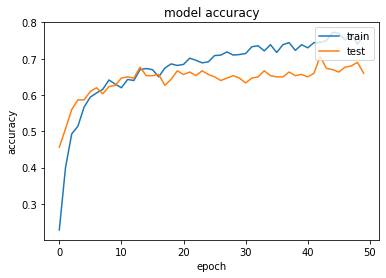

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

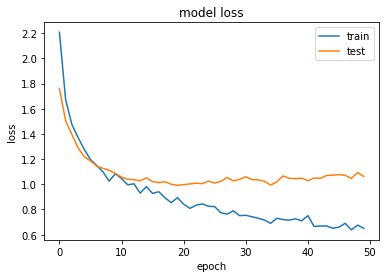

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
# plt.savefig('figures/4.4a_1.png')

#Question 2


In [ ]:
def compute_model(X,Y,num_folds,batch_size):
  num_data=X.shape[0]
  nf = num_data//num_folds
  kf = KFold(num_folds)
  for train_index, validation_index in kf.split(X):
    train_x, val_x = X[train_index], X[validation_index]
    train_y, val_y = Y[train_index], Y[validation_index]

    model=Sequential([
      Dense(16, activation='relu'),
      Dropout(0.3),
      Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                    loss=tf.keras.losses.CategoricalCrossentropy(),
                    metrics=[tf.keras.losses.CategoricalCrossentropy(name='ce'),'accuracy'])
      
    history = model.fit(train_x, train_y, 
                            epochs=num_epochs, 
                            batch_size = batch_size,
                            validation_data=(val_x,val_y))
  return history

In [ ]:
batch_sizes=[1,4,8,16,32, 64]
accuracy=[]
mean_accuracy={}
num_folds=3
#replace X_train and Y_train with X and Y
for size in batch_sizes:
  history=compute_model(X_train,y_train,num_folds,size)
  accuracy.append(history.history['val_accuracy'][num_epochs-1])
  mean_accuracy[size]=np.mean(accuracy)
print(mean_accuracy)


Epoch 1/50
466/466 [==============================] - 3s 4ms/step - loss: 2.3267 - ce: 2.3267 - accuracy: 0.1738 - val_loss: 1.8774 - val_ce: 1.8774 - val_accuracy: 0.3462
Epoch 2/50
466/466 [==============================] - 2s 3ms/step - loss: 1.8688 - ce: 1.8688 - accuracy: 0.3627 - val_loss: 1.6586 - val_ce: 1.6586 - val_accuracy: 0.4060
Epoch 3/50
466/466 [==============================] - 2s 4ms/step - loss: 1.6295 - ce: 1.6295 - accuracy: 0.4227 - val_loss: 1.5202 - val_ce: 1.5202 - val_accuracy: 0.4274
Epoch 4/50
466/466 [==============================] - 2s 3ms/step - loss: 1.5345 - ce: 1.5345 - accuracy: 0.4721 - val_loss: 1.3872 - val_ce: 1.3872 - val_accuracy: 0.5000
Epoch 5/50
466/466 [==============================] - 2s 4ms/step - loss: 1.4912 - ce: 1.4912 - accuracy: 0.4506 - val_loss: 1.3157 - val_ce: 1.3157 - val_accuracy: 0.5342
Epoch 6/50
466/466 [==============================] - 2s 3ms/step - loss: 1.3780 - ce: 1.3780 - accuracy: 0.5064 - val_loss: 1.2562 - val_ce

Text(0, 0.5, 'cross-validation accuracy')

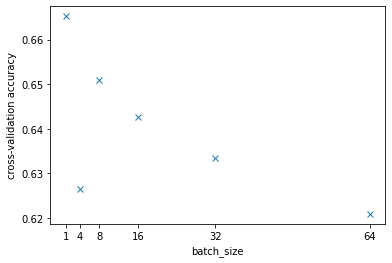

In [ ]:
plt.plot(batch_sizes, [value for key,value in mean_accuracy.items()] , marker = 'x', linestyle = 'None')
plt.xticks(batch_sizes)
plt.xlabel('batch_size')
plt.ylabel('cross-validation accuracy')

In [ ]:
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.times=[]
    def on_train_batch_begin(self, batch, logs={}):
        self.starttime = time.time()
    def on_train_batch_end(self, batch, logs={}):
        self.times.append(time.time()-self.starttime)



In [ ]:
median_time={}
def median_time_taken(batch_size,X,Y):
  accuracy=[]
  num_data=X.shape[0]
  nf = num_data//num_folds
  kf = KFold(num_folds)
  for train_index, validation_index in kf.split(X):
    train_x, val_x = X[train_index], X[validation_index]
    train_y, val_y = Y[train_index], Y[validation_index] 

    model=Sequential([
      Dense(16, activation='relu'),
      Dropout(0.3),
      Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                    loss=tf.keras.losses.CategoricalCrossentropy(),
                    metrics=[tf.keras.losses.CategoricalCrossentropy(name='ce'),'accuracy'])
    cb = TimingCallback()
    history = model.fit(train_x, train_y, 
                            epochs=1, 
                            batch_size = batch_size,
                            verbose=2,
                            use_multiprocessing=True,
                            callbacks = [cb],
                            validation_data=(val_x, val_y))
  
  median_time[batch_size]=np.median(cb.times)

In [ ]:
batch_sizes=[1,4,8,16,32, 64]
#replace X_train and Y_train with X and Y
for size in batch_sizes:
  median_time_taken(size,X_train,y_train)
print(median_time)

466/466 - 2s - loss: 2.3610 - ce: 2.3610 - accuracy: 0.1717 - val_loss: 1.8989 - val_ce: 1.8989 - val_accuracy: 0.3291
467/467 - 2s - loss: 2.2654 - ce: 2.2654 - accuracy: 0.1991 - val_loss: 1.9182 - val_ce: 1.9182 - val_accuracy: 0.3262
467/467 - 2s - loss: 2.4241 - ce: 2.4241 - accuracy: 0.1606 - val_loss: 2.0948 - val_ce: 2.0948 - val_accuracy: 0.2489
117/117 - 1s - loss: 2.5748 - ce: 2.5723 - accuracy: 0.1245 - val_loss: 2.1431 - val_ce: 2.1489 - val_accuracy: 0.2308
117/117 - 1s - loss: 2.4309 - ce: 2.4303 - accuracy: 0.1906 - val_loss: 2.1257 - val_ce: 2.1283 - val_accuracy: 0.2661
117/117 - 1s - loss: 2.4609 - ce: 2.4599 - accuracy: 0.1563 - val_loss: 2.0771 - val_ce: 2.0677 - val_accuracy: 0.2232
59/59 - 1s - loss: 2.4724 - ce: 2.4620 - accuracy: 0.1524 - val_loss: 2.1925 - val_ce: 2.1889 - val_accuracy: 0.2692
59/59 - 1s - loss: 2.6214 - ce: 2.6224 - accuracy: 0.1006 - val_loss: 2.3514 - val_ce: 2.3400 - val_accuracy: 0.1588
59/59 - 1s - loss: 2.6972 - ce: 2.6880 - accuracy: 0

In [ ]:
print ("{:<10} {:<10}".format('Batch Size', 'Median time taken'))
 
# print each data item.
for key, value in median_time.items():
    print ("{:<10} {:<10}".format(key, value))

Text(0, 0.5, 'median times')

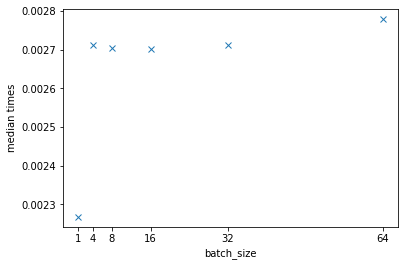

In [ ]:
plt.plot(batch_sizes, [value for key,value in median_time.items()] , marker = 'x', linestyle = 'None')
plt.xticks(batch_sizes)
plt.xlabel('batch_size')
plt.ylabel('median times')

Optimal btch size=8

In [ ]:
  size=8
  history=compute_model(X_train,y_train,num_folds,size)

Epoch 1/50
59/59 [==============================] - 1s 13ms/step - loss: 2.4828 - ce: 2.4898 - accuracy: 0.1073 - val_loss: 2.1419 - val_ce: 2.1291 - val_accuracy: 0.2094
Epoch 2/50
59/59 [==============================] - 0s 4ms/step - loss: 2.1265 - ce: 2.1145 - accuracy: 0.2189 - val_loss: 1.8949 - val_ce: 1.8906 - val_accuracy: 0.3462
Epoch 3/50
59/59 [==============================] - 0s 5ms/step - loss: 1.9494 - ce: 1.9468 - accuracy: 0.2983 - val_loss: 1.7543 - val_ce: 1.7552 - val_accuracy: 0.3932
Epoch 4/50
59/59 [==============================] - 0s 4ms/step - loss: 1.8130 - ce: 1.8245 - accuracy: 0.3262 - val_loss: 1.6567 - val_ce: 1.6629 - val_accuracy: 0.4231
Epoch 5/50
59/59 [==============================] - 0s 5ms/step - loss: 1.7097 - ce: 1.7027 - accuracy: 0.3970 - val_loss: 1.5830 - val_ce: 1.5919 - val_accuracy: 0.4573
Epoch 6/50
59/59 [==============================] - 0s 6ms/step - loss: 1.6156 - ce: 1.6091 - accuracy: 0.4077 - val_loss: 1.5264 - val_ce: 1.5381 - 

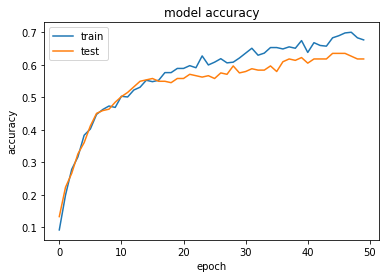

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

#Question 3

In [ ]:
hidden_units = [8, 16, 32, 64]

In [ ]:
def hidden_neurons(neurons_hidden,X,Y):
  num_data=X.shape[0]
  num_epochs=50
  batch_size=8
  num_folds=3
  nf = num_data//num_folds
  kf = KFold(num_folds)
  for train_index, validation_index in kf.split(X):
    train_x, val_x = X[train_index], X[validation_index]
    train_y, val_y = Y[train_index], Y[validation_index] 

    model=Sequential([
      Dense(neurons_hidden, activation='relu'),
      Dropout(0.3),
      Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                    loss=tf.keras.losses.CategoricalCrossentropy(),
                    metrics=[tf.keras.losses.CategoricalCrossentropy(name='ce'),'accuracy'])
      
    history = model.fit(train_x, train_y, 
                            epochs=num_epochs, 
                            batch_size = batch_size,
                            validation_data=(val_x,val_y))
  return history

In [ ]:
accuracy=[]
neurons_number={}
for neuron in hidden_units:
  history=hidden_neurons(neuron,X_train,y_train)
  accuracy.append(history.history['val_accuracy'][num_epochs-1])
  neurons_number[neuron]=np.mean(accuracy)

Epoch 1/50
59/59 [==============================] - 1s 9ms/step - loss: 2.4679 - ce: 2.4691 - accuracy: 0.1588 - val_loss: 2.2091 - val_ce: 2.2151 - val_accuracy: 0.1966
Epoch 2/50
59/59 [==============================] - 0s 4ms/step - loss: 2.2412 - ce: 2.2422 - accuracy: 0.2232 - val_loss: 2.0939 - val_ce: 2.1014 - val_accuracy: 0.2650
Epoch 3/50
59/59 [==============================] - 0s 4ms/step - loss: 2.1030 - ce: 2.1141 - accuracy: 0.2554 - val_loss: 2.0176 - val_ce: 2.0280 - val_accuracy: 0.2991
Epoch 4/50
59/59 [==============================] - 0s 5ms/step - loss: 2.0445 - ce: 2.0408 - accuracy: 0.2811 - val_loss: 1.9433 - val_ce: 1.9537 - val_accuracy: 0.3248
Epoch 5/50
59/59 [==============================] - 0s 5ms/step - loss: 1.9881 - ce: 1.9871 - accuracy: 0.2897 - val_loss: 1.8900 - val_ce: 1.9030 - val_accuracy: 0.3889
Epoch 6/50
59/59 [==============================] - 0s 5ms/step - loss: 1.9192 - ce: 1.9173 - accuracy: 0.2854 - val_loss: 1.8236 - val_ce: 1.8397 - v

Text(0.5, 0, 'neurons')

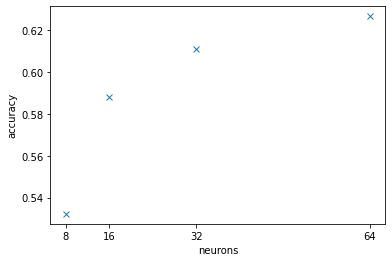

In [ ]:
plt.plot(hidden_units, [value for key,value in neurons_number.items()] , marker = 'x', linestyle = 'None')
plt.xticks(hidden_units)
# plt.xlabel('batch_size')
# plt.ylabel('median times')
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('neurons')

We will try with 32 neurons first and then 64 neurons


In [ ]:
optimal_neurons=16
history=hidden_neurons(optimal_neurons, X_train,y_train)

Epoch 1/50
59/59 [==============================] - 1s 9ms/step - loss: 2.5256 - ce: 2.5284 - accuracy: 0.1094 - val_loss: 2.2467 - val_ce: 2.2502 - val_accuracy: 0.1923
Epoch 2/50
59/59 [==============================] - 0s 5ms/step - loss: 2.1564 - ce: 2.1468 - accuracy: 0.2403 - val_loss: 2.0585 - val_ce: 2.0656 - val_accuracy: 0.2991
Epoch 3/50
59/59 [==============================] - 0s 4ms/step - loss: 2.0312 - ce: 2.0254 - accuracy: 0.2747 - val_loss: 1.9211 - val_ce: 1.9296 - val_accuracy: 0.3462
Epoch 4/50
59/59 [==============================] - 0s 5ms/step - loss: 1.8875 - ce: 1.8841 - accuracy: 0.3369 - val_loss: 1.8112 - val_ce: 1.8207 - val_accuracy: 0.4145
Epoch 5/50
59/59 [==============================] - 0s 5ms/step - loss: 1.8108 - ce: 1.8139 - accuracy: 0.3798 - val_loss: 1.7285 - val_ce: 1.7383 - val_accuracy: 0.4316
Epoch 6/50
59/59 [==============================] - 0s 5ms/step - loss: 1.7003 - ce: 1.6913 - accuracy: 0.3991 - val_loss: 1.6511 - val_ce: 1.6622 - v

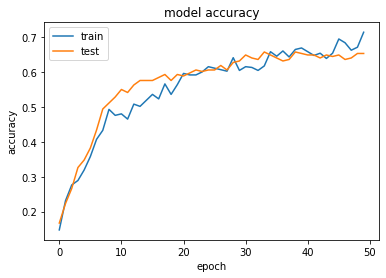

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
optimal_neurons=32
history=hidden_neurons(optimal_neurons, X_train,y_train)

Epoch 1/50
59/59 [==============================] - 1s 8ms/step - loss: 2.5373 - ce: 2.5333 - accuracy: 0.1609 - val_loss: 2.1760 - val_ce: 2.1710 - val_accuracy: 0.2265
Epoch 2/50
59/59 [==============================] - 0s 5ms/step - loss: 2.0971 - ce: 2.0949 - accuracy: 0.2618 - val_loss: 1.8396 - val_ce: 1.8392 - val_accuracy: 0.3376
Epoch 3/50
59/59 [==============================] - 0s 4ms/step - loss: 1.7425 - ce: 1.7351 - accuracy: 0.4163 - val_loss: 1.6343 - val_ce: 1.6395 - val_accuracy: 0.4231
Epoch 4/50
59/59 [==============================] - 0s 5ms/step - loss: 1.6017 - ce: 1.6085 - accuracy: 0.4506 - val_loss: 1.5008 - val_ce: 1.5088 - val_accuracy: 0.4530
Epoch 5/50
59/59 [==============================] - 0s 5ms/step - loss: 1.5004 - ce: 1.5045 - accuracy: 0.4828 - val_loss: 1.4010 - val_ce: 1.4102 - val_accuracy: 0.4872
Epoch 6/50
59/59 [==============================] - 0s 4ms/step - loss: 1.4037 - ce: 1.4073 - accuracy: 0.5150 - val_loss: 1.3455 - val_ce: 1.3559 - v

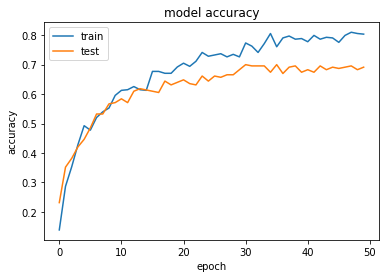

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
optimal_neurons=64
history=hidden_neurons(optimal_neurons, X_train,y_train)

Epoch 1/50
59/59 [==============================] - 1s 8ms/step - loss: 2.0575 - ce: 2.0646 - accuracy: 0.2618 - val_loss: 1.7057 - val_ce: 1.7381 - val_accuracy: 0.4658
Epoch 2/50
59/59 [==============================] - 0s 4ms/step - loss: 1.5884 - ce: 1.5872 - accuracy: 0.4464 - val_loss: 1.4877 - val_ce: 1.5246 - val_accuracy: 0.5128
Epoch 3/50
59/59 [==============================] - 0s 6ms/step - loss: 1.3901 - ce: 1.3755 - accuracy: 0.5279 - val_loss: 1.3681 - val_ce: 1.4072 - val_accuracy: 0.5214
Epoch 4/50
59/59 [==============================] - 0s 4ms/step - loss: 1.2580 - ce: 1.2476 - accuracy: 0.5730 - val_loss: 1.2661 - val_ce: 1.3058 - val_accuracy: 0.5684
Epoch 5/50
59/59 [==============================] - 0s 6ms/step - loss: 1.2061 - ce: 1.1964 - accuracy: 0.5708 - val_loss: 1.1990 - val_ce: 1.2410 - val_accuracy: 0.5983
Epoch 6/50
59/59 [==============================] - 0s 5ms/step - loss: 1.1173 - ce: 1.1109 - accuracy: 0.6073 - val_loss: 1.1419 - val_ce: 1.1874 - v

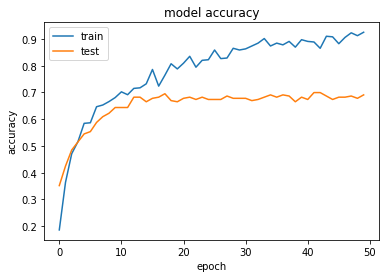

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

What parameters can be tuned

#Question 4


In [ ]:
num_data=X_train.shape[0]
num_epochs=50
batch_size=1
num_folds=3
neurons_per_layer=16
nf = num_data//num_folds
kf = KFold(num_folds)
for train_index, validation_index in kf.split(X_train):
  train_x, val_x = X_train[train_index], X_train[validation_index]
  train_y, val_y = y_train[train_index], y_train[validation_index] 

  model=Sequential([
    Dense(neurons_per_layer, activation='relu'),
    Dropout(0.3),
    Dense(neurons_per_layer, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
  ])
  
  model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.losses.CategoricalCrossentropy(name='ce'),'accuracy'])
    
  history = model.fit(train_x, train_y, 
                          epochs=num_epochs, 
                          batch_size = batch_size,
                          validation_data=(val_x,val_y))

Epoch 1/50
466/466 [==============================] - 3s 5ms/step - loss: 2.3380 - ce: 2.3380 - accuracy: 0.1567 - val_loss: 1.9041 - val_ce: 1.9041 - val_accuracy: 0.3632
Epoch 2/50
466/466 [==============================] - 2s 4ms/step - loss: 1.8974 - ce: 1.8974 - accuracy: 0.3026 - val_loss: 1.6061 - val_ce: 1.6061 - val_accuracy: 0.4786
Epoch 3/50
466/466 [==============================] - 2s 4ms/step - loss: 1.6363 - ce: 1.6363 - accuracy: 0.4142 - val_loss: 1.4247 - val_ce: 1.4247 - val_accuracy: 0.5214
Epoch 4/50
466/466 [==============================] - 2s 4ms/step - loss: 1.5337 - ce: 1.5337 - accuracy: 0.4185 - val_loss: 1.3086 - val_ce: 1.3086 - val_accuracy: 0.5513
Epoch 5/50
466/466 [==============================] - 2s 4ms/step - loss: 1.3956 - ce: 1.3956 - accuracy: 0.4871 - val_loss: 1.2787 - val_ce: 1.2787 - val_accuracy: 0.5513
Epoch 6/50
466/466 [==============================] - 2s 4ms/step - loss: 1.3088 - ce: 1.3088 - accuracy: 0.5129 - val_loss: 1.2178 - val_ce

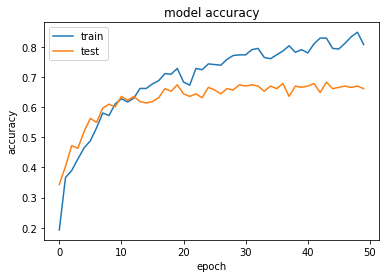

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

#Question 5


In [ ]:
model=Sequential([
    Dense(16, activation='relu'),
    #Dropout(0.3),
    Dense(10, activation='softmax')
])

In [ ]:
num_epochs=50
batch_size=1

model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=
              [#tf.keras.losses.CategoricalCrossentropy(name='ce'),
               'accuracy'])
    
history = model.fit(X_train, y_train, 
                        epochs=num_epochs, 
                        batch_size = batch_size,
                        validation_data=(X_test,y_test))

Epoch 1/50
700/700 [==============================] - 3s 3ms/step - loss: 1.9047 - accuracy: 0.3329 - val_loss: 1.5903 - val_accuracy: 0.4167
Epoch 2/50
700/700 [==============================] - 2s 3ms/step - loss: 1.3701 - accuracy: 0.4986 - val_loss: 1.3376 - val_accuracy: 0.4933
Epoch 3/50
700/700 [==============================] - 2s 3ms/step - loss: 1.1258 - accuracy: 0.6000 - val_loss: 1.2224 - val_accuracy: 0.5733
Epoch 4/50
700/700 [==============================] - 2s 3ms/step - loss: 0.9603 - accuracy: 0.6743 - val_loss: 1.1633 - val_accuracy: 0.6033
Epoch 5/50
700/700 [==============================] - 2s 3ms/step - loss: 0.8594 - accuracy: 0.7243 - val_loss: 1.1038 - val_accuracy: 0.6100
Epoch 6/50
700/700 [==============================] - 2s 3ms/step - loss: 0.7735 - accuracy: 0.7429 - val_loss: 1.0875 - val_accuracy: 0.6400
Epoch 7/50
700/700 [==============================] - 2s 3ms/step - loss: 0.7078 - accuracy: 0.7614 - val_loss: 1.0702 - val_accuracy: 0.6400
Epoch 

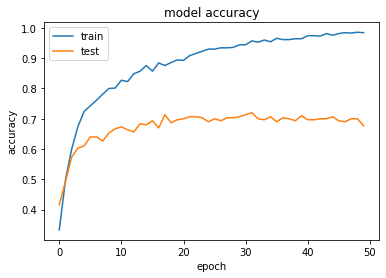

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')